<h2> Project Description </h2> 
<br> The overall idea of this project is to draw blocks on an image, using a reinforced CNN model, such that the overall entropy in the image is minimized.  
<br> For this we start with a blank image, which by nature would have the minimum possible entropy of zero. However, as we need the model to draw blocks, I have hardcoded an entropy of ten for blank rows/columns in the image. This would ensure a low reward for empty spaces left in the original image. The reward given to the model for its actions will be inversely proportional to the entropy in the image (and directly proportional to the order). 
<br> The blank image has a dimension of 30X30 and the blocks to be placed on it one at a time have dimensions 3X3. <br> 
<h3> A deep Q-learning method is implemented where: </h3>
<ul>
    <li> The <b>state</b> is the image. </li>
    <li> The <b>action</b> is placing a block (from a choice of blocks), on a range of possible x-y coordinates in the image. The possible coordinates for placing the blocks are defined such that the blocks fit accurately on the image, and blocks could either completely overlap or are placed in an unused, non-overlapping location. So, for the 30X30 image with 3X3 blocks, there are 10X10 = 100 possible locations. Each action returns a new image/state from a previous image/state, with either a higher or lower entropy. </li>
    <li> The <b> Q-Value or Reward </b> is the reward associated by taking some action on a state. In this case, the reward is defined by counting the total number of non-zero pixels in the image and multiplying it with 'some_constant' / (entropy of the image). The input to the model would be an image and the output would the predicted q-value for every possible action on that image.</li></ul>
    
<h3> What inspired this experiment? </h3>
<br> I believe that as 'intelligent' species we exist on this planet to capture and create order in the semi-chaotic environment around us. As such, our sense of beauty is biased towards higher order. However, though a completely black or white image has the lowest entropy of 0, 'magic' happens when you add 'just enough' entropy. So, we start with high entropy blocks to test if an Artificial Intelligence could mimic life's thirst for order and generate images that 'appear beautiful' to its natural counterpart. 

<h3> Imports </h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

# imports from keras 
from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Model, load_model

c:\users\mrinal\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h3> Data Definitions </h3>

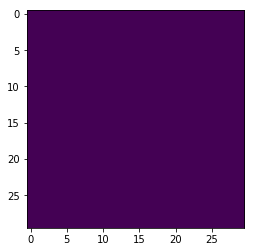

In [2]:
# constant dimensions
HEIGHT = 30
WIDTH = 30 

# defining a blank image
image = np.zeros((HEIGHT,WIDTH), dtype='int8')
plt.imshow(image)

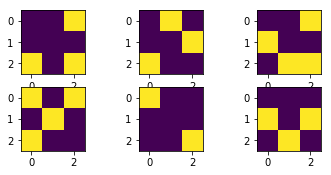

In [3]:
# defining the blocks 
block1 = [[0,0,1], [0,0,0], [1,0,1]]
block2 = [[0,1,0], [0,0,1], [1,0,0]]
block3 = [[0,0,1], [1,0,0], [0,1,1]]
block4 = [[1,0,1], [0,1,0], [1,0,0]]
block5 = [[1,0,0], [0,0,0], [0,0,1]]
#block6 = [[1,1,1], [0,1,0], [0,1,0]]
#block7 = [[0,1,0], [0,1,0], [1,0,1]]
block8 = [[0,0,0], [1,0,1], [0,1,0]]
#block9 = [[1,0,1], [1,1,1], [0,1,0]]

all_blocks = np.array([block1, block2, block3, 
                       block4, block5, block8], dtype='int8')

fig=plt.figure()
for i in range(1,len(all_blocks)+1):
    img = all_blocks[i-1]
    fig.add_subplot(3, 3, i)
    plt.imshow(img)
plt.show()

In [4]:
# defining all possible locations where the blocks can be placed in the image 
x_locations = list(range(1,HEIGHT-1,3))
y_locations = list(range(1,WIDTH-1,3))
all_possible_locations = [(x,y) for x in x_locations for y in y_locations]
print(len(all_possible_locations))

# combining locations and blocks to give the complete range of possible actions
block_range = list(range(len(all_blocks)))
all_actions = [(x, y[0], y[1]) for x in block_range for y in all_possible_locations] 
print(len(all_actions))

100
600


<h3> Model Design </h3> 

In [20]:
# designing the conv. neural network

input_img = Input(shape=(HEIGHT, WIDTH,1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(len(all_actions), activation = 'relu')(x)
output = Dense(len(all_actions))(x)

cnn = Model(input_img, output)
cnn.compile(optimizer='nadam', loss='mse') 

# Notes 
# Pooling layers not added as location information is important.
# The last layer does not have an activation to handle negative rewards.

<h3> Function Definitions </h3>

In [21]:
# function to place a block in the x,y co-ordinates of the image. 
# returns a copy image. 
def place_block(image, block, x, y):
    x_start = x-1 
    x_stop = x+2
    y_start = y-1 
    y_stop = y+2
    
    res = np.copy(image)
    res[x_start:x_stop, y_start:y_stop] = block
    
    return res
        
# function to return log base 2
def ln(x):
    return log(x)/log(2)

# to get the entropy of a particular row/column in an image.
# Harcoding entropy as 1 for a row without any activated pixel as we want 
# the model to learn to draw stuff instead of leaving rows/column blank.
def get_slice_entropy(slce):
    n = len(slce)
    ones = np.count_nonzero(slce)
    if ones == 0:
        return 10
    else:
        zeros = n - ones
        p_ones = max(0.000001, ones / n)     # 0.000001 is added to avoid math error with log(0)/log(2)
        p_zeros = max(0.000001, zeros / n)   
        return (p_ones*ln(p_ones) + p_zeros*ln(p_zeros)) * -1

# to sum and return entropy for all rows and columns
def get_entropy(image):
    row_entropy = sum(np.apply_along_axis(get_slice_entropy, 0, image))
    col_entropy = sum(np.apply_along_axis(get_slice_entropy, 1, image))
    return row_entropy + col_entropy
    
# The reward is made inversely proportional to the entropy in the image,
# hence, directly proportional to the 'order' in the image.
# Also, count of non-zero elements ensures that the model achieves a higher reward 
# for filling in blank spaces in the image. 
def get_reward(image):
    score = np.count_nonzero(image) * 60 / get_entropy(image) 
    return score
    
# The reinforced training of the model can be seen as a game. 
# The game is initialized with a random block placed on a random location of a blank image. 
# The model then gets 'num_attempts' on the image to fill it with blocks iteratively. 
# The reward fed to the model should ensure the model learns to reduce entropy in the image,
# all while anticipating future rewards for the current action. 
def play_round(cnn, num_attempts, exploration=0.5):
    image = np.zeros((HEIGHT, WIDTH), dtype='int8')
    random_action = all_actions[np.random.randint(0,len(all_actions))]
    current_image = place_block(image, 
                                all_blocks[random_action[0]], 
                                random_action[1],
                                random_action[2])
    total_reward = 0
    decay_factor = 0.998
    locations_taken = []
    for _ in range(num_attempts):
        exploration *= decay_factor
        reshaped = current_image.reshape(1,HEIGHT, WIDTH,1)
        action_qs = cnn.predict(reshaped)
        
        # exploration vs exploitation for choosing the action
        if np.random.random() < exploration:
            chosen_action = np.random.randint(0,len(all_actions))
        else:
            chosen_action = np.argmax(action_qs)
        
        action_tuple = all_actions[chosen_action]
        location = (action_tuple[1], action_tuple[2])
        # penalized reward for overwriting a block
        if location in locations_taken:
            reward = -40
        else:
            locations_taken.append(location)
            # applying action to state/image
            new_image = place_block(current_image, 
                                    all_blocks[action_tuple[0]], 
                                    action_tuple[1],
                                    action_tuple[2])

            # calculating reward from applying the chosen action to the image
            # old_reward = get_reward(current_image)
            new_reward = get_reward(new_image) 

            # calculating future reward for the new image
            reshaped_new = new_image.reshape(1,HEIGHT, WIDTH,1)
            future_action = cnn.predict(reshaped_new)
            future_chosen_act = np.argmax(future_action)
            future_act_tuple = all_actions[future_chosen_act]
            future_location = (future_act_tuple[1], future_act_tuple[2])
            
            if future_location in locations_taken: # penalized reward for overwriting a block in the future
                future_reward = -40
            else:
                future_image = place_block(new_image,
                                      all_blocks[future_act_tuple[0]], 
                                      future_act_tuple[1],
                                      future_act_tuple[2])
                future_reward = get_reward(future_image) 
            
            # discounted future reward is added to the current reward for reinforcecment
            reward = new_reward + 0.8*future_reward
            
            
        # updating targets with the new reward
        target_action = action_qs
        target_action[0][chosen_action] = reward 
        
        # training with the new targets
        cnn.fit(reshaped, target_action, epochs=1, verbose=0)
        
        total_reward += reward  
        current_image = new_image
    
    avg_reward = total_reward / num_attempts
    return (avg_reward, current_image)

# function to plot images 
def plot_images(list_images):
    n = len(list_images)
    rows = n//3 + 1
    fig=plt.figure(figsize=(18,18))
    for i in range(1,n+1):
        img = list_images[i-1]
        fig.add_subplot(rows, 3, i)
        plt.imshow(img)
    plt.show()

<h3> Reinforced Training </h3>  

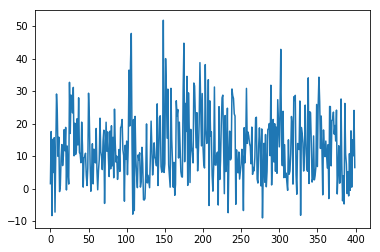

In [22]:
rewards = []
best_rewards = 0
lowest_entropy = 60
best_images = []
entropies = []
num_rounds = 400        # no of rounds
num_attempts = 100      # no of attempts in each round 

for _ in range(num_rounds): 
    avg_reward, current_image = play_round(cnn, num_attempts, 0.6)
    rewards.append(avg_reward)
    entropy = get_entropy(current_image)
    if (avg_reward > best_rewards) and (entropy < lowest_entropy):
        entropies.append(entropy)
        best_images.append(current_image)
        cnn.save('v1.h5')
        lowest_entropy = entropy
        best_rewards = avg_reward
            
# plot rewards
plt.plot(list(range(len(rewards))), rewards)

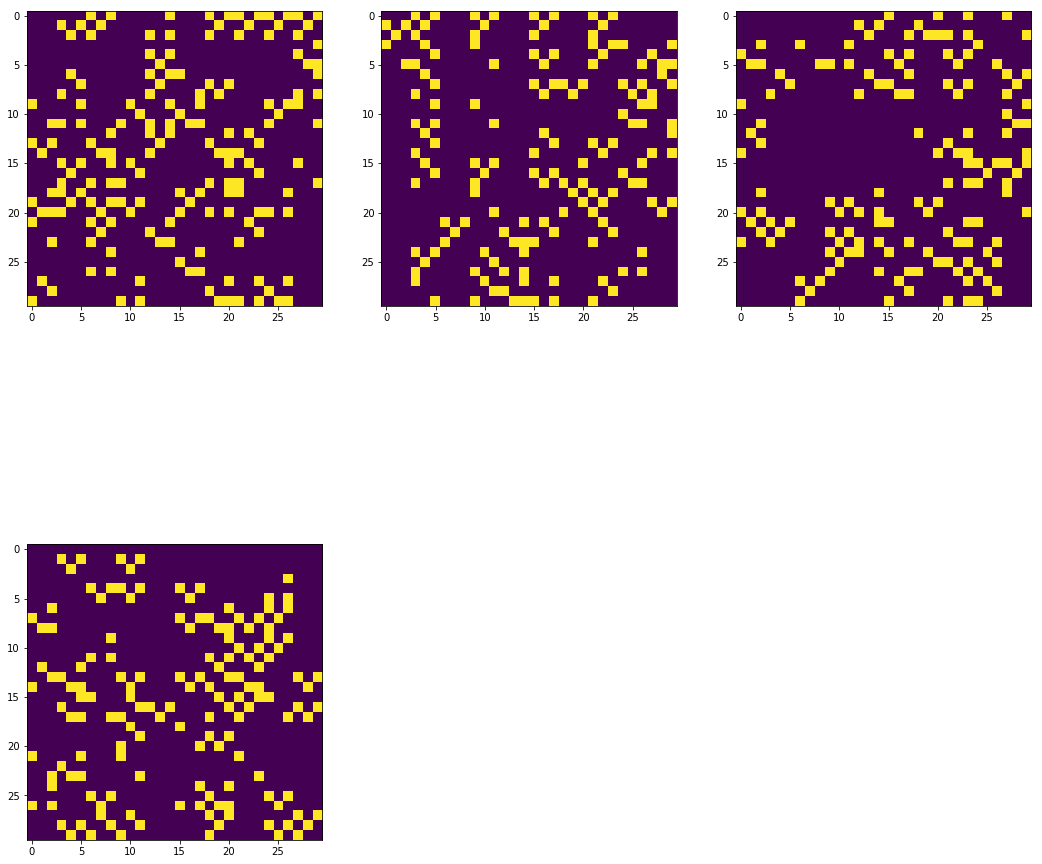

In [23]:
plot_images(best_images)

<h3> This might look pretty random and noisy because of the high exploration value </h3> 

In [24]:
print (entropies)

[39.77649722327986, 36.73952570007923, 35.86889853404459, 28.561041889682805]


<h3>Testing the AI </h3>

In [25]:
cnn = load_model('v1.h5')

In [26]:
def play(cnn, num_attempts):
    image = np.zeros((HEIGHT, WIDTH), dtype='int8')
    random_action = all_actions[np.random.randint(0,len(all_actions))]
    current_image = place_block(image, 
                                all_blocks[random_action[0]], 
                                random_action[1],
                                random_action[2])
    total_reward = 0
    actions_not_taken = np.ones(len(all_actions), dtype ='bool_')
    exploration = 0.1
    for _ in range(num_attempts): 
        
        reshaped = current_image.reshape(1,HEIGHT, WIDTH,1)
        action_qs = cnn.predict(reshaped)
        
        # predicting and choosing an actions, filtered by actions not yet taken
        filtered_actions = action_qs[0][actions_not_taken]
        
        # exploration vs exploitation for choosing the action
        if np.random.random() < exploration:
            chosen_action = np.random.randint(0,len(all_actions))
        else:
            chosen_action = np.argmax(filtered_actions) 
            
        actions_not_taken[chosen_action] = False 
        
        # applying action to state/image
        action_tuple = all_actions[chosen_action]
        new_image = place_block(current_image, 
                                all_blocks[action_tuple[0]], 
                                action_tuple[1],
                                action_tuple[2])
                            
        # calculating reward from applying the chosen action to the image
        new_reward = get_reward(new_image) 
        
        total_reward += new_reward  
        current_image = new_image
    
    avg_reward = total_reward / num_attempts
    return (avg_reward, current_image)      

<h3> The above code is run with a low exploration value and also allows for overwriting some blocks incase num_attempts > 100 </h3>

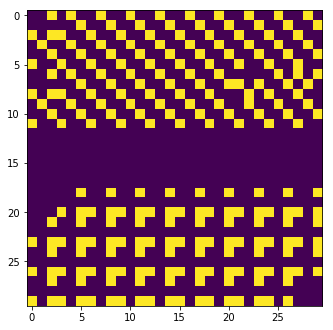

In [27]:
num_attempts = 100      # no of attempts in each round 
avg_reward, curr_image = play(cnn, num_attempts)
plot_images([curr_image])

<h3> The model seems to be biased towards the least entropic repeating patterns where pixels are distributed alternately. </h3>

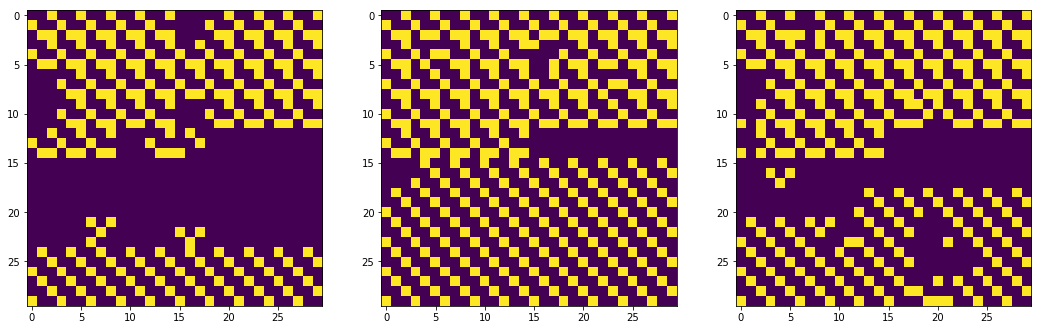

In [28]:
num_attempts = 100      # no of attempts in each round 
res_images = []
for _ in range(3):
    avg_reward, curr_image = play(cnn, num_attempts)
    res_images.append(curr_image)
plot_images(res_images)

<h3>  However, when I accidentally entered a large number for num_attempts, some alternate distributions emerged. </h3> 

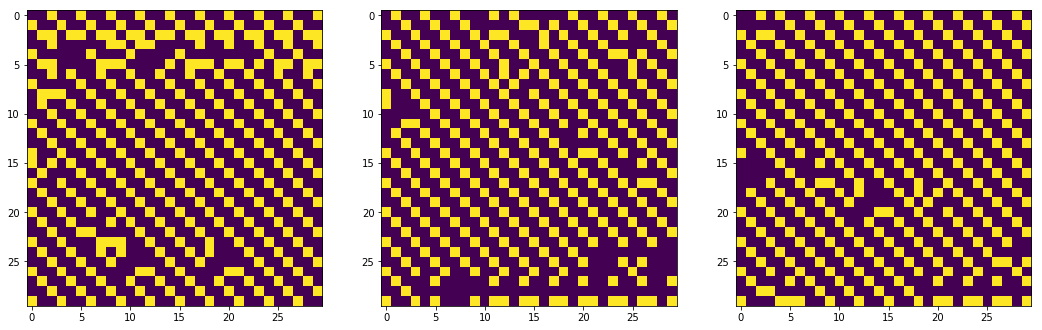

In [36]:
num_attempts = 250      # no of attempts in each round 
res_images = []
for _ in range(3):
    avg_reward, curr_image = play(cnn, num_attempts)
    res_images.append(curr_image)
plot_images(res_images)

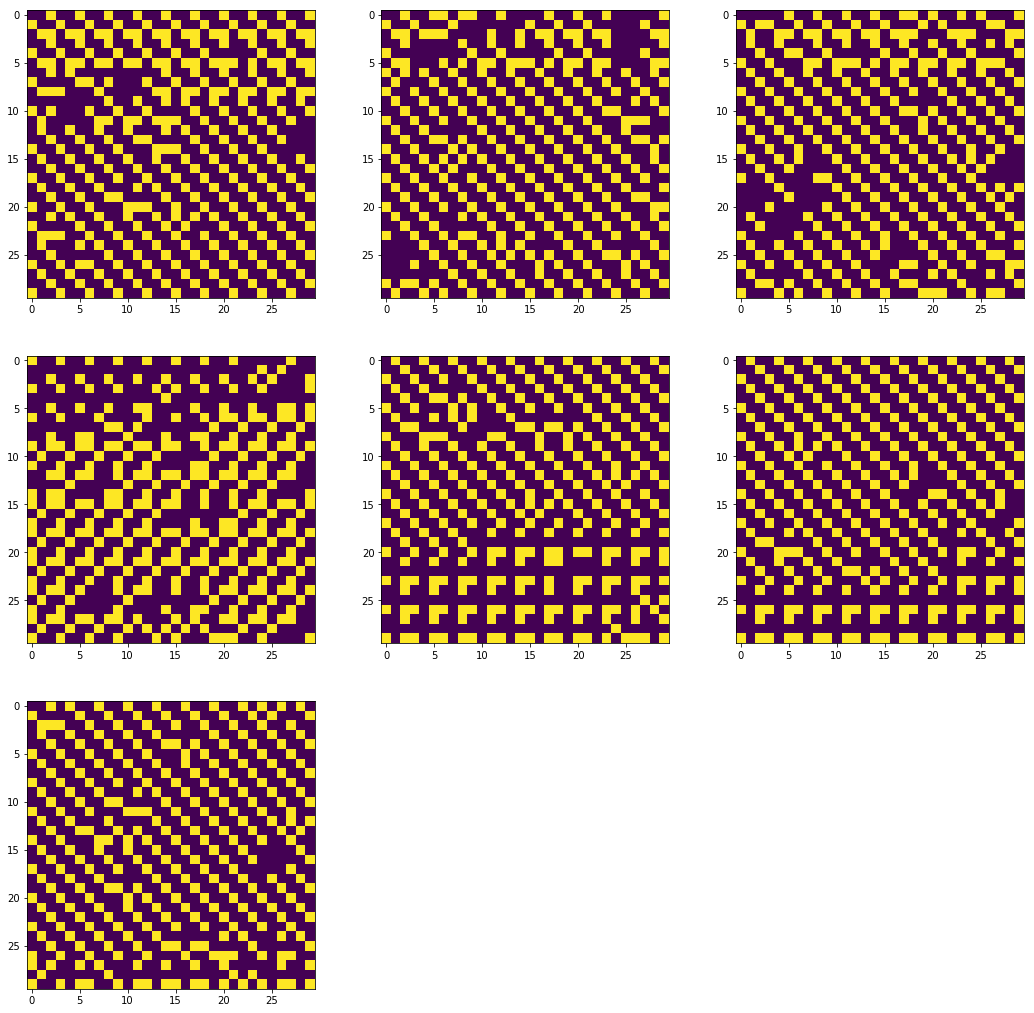

In [33]:
num_attempts = 300      # no of attempts in each round 
res_images = []
for _ in range(7):
    avg_reward, curr_image = play(cnn, num_attempts)
    res_images.append(curr_image)
plot_images(res_images)

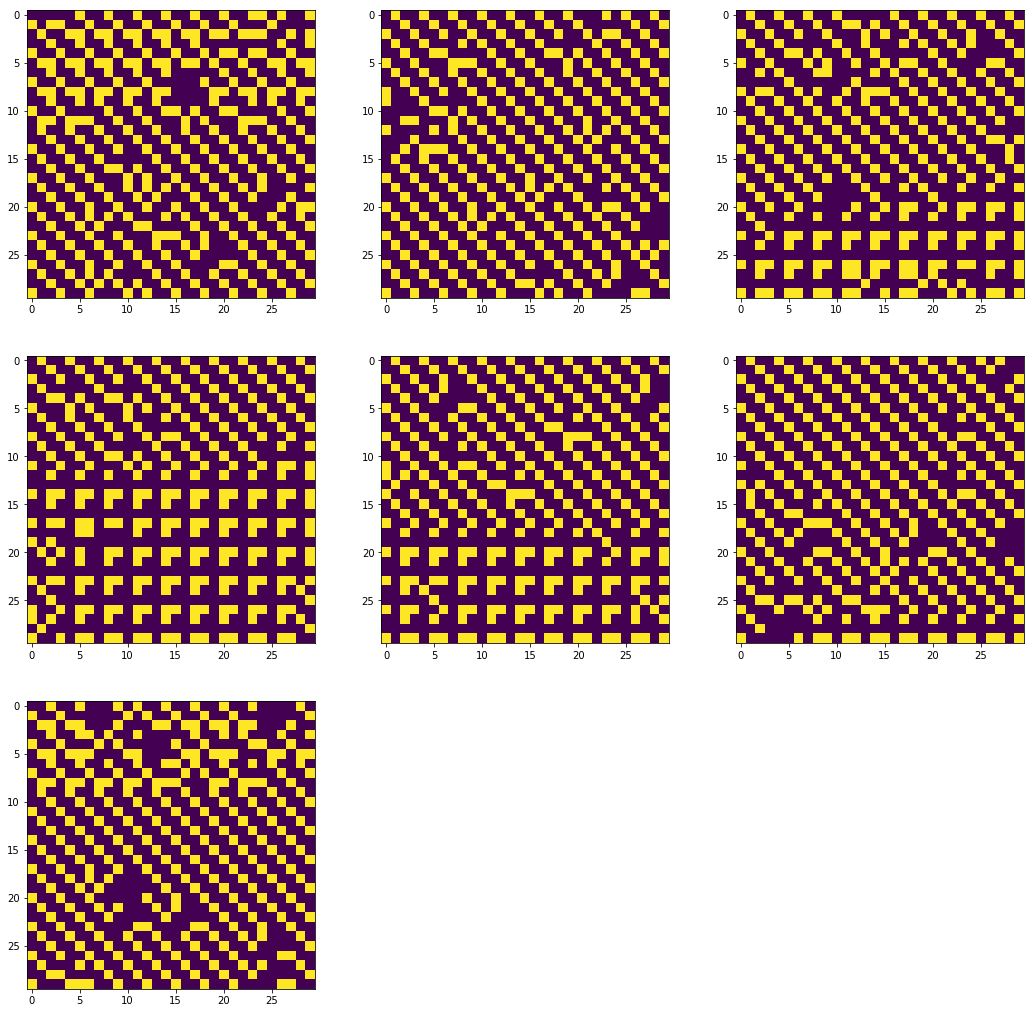

In [34]:
num_attempts = 350      # no of attempts in each round 
res_images = []
for _ in range(7):
    avg_reward, curr_image = play(cnn, num_attempts)
    res_images.append(curr_image)
plot_images(res_images)